In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

### 1. Checking and cleaning original data

In [202]:
df = pd.read_csv('Housing.csv')

In [203]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [205]:
df.shape

(545, 13)

In [206]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,545,545,545,545,545,545
mean,4766729,5151,3,1,2,1
std,1870440,2170,1,1,1,1
min,1750000,1650,1,1,1,0
25%,3430000,3600,2,1,1,0
50%,4340000,4600,3,1,2,0
75%,5740000,6360,3,2,2,1
max,13300000,16200,6,4,4,3


In [207]:
df.isnull().sum()  # null values check

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [208]:
df.duplicated().sum()

0

Text(0.5, 1.0, 'Distribution of Price')

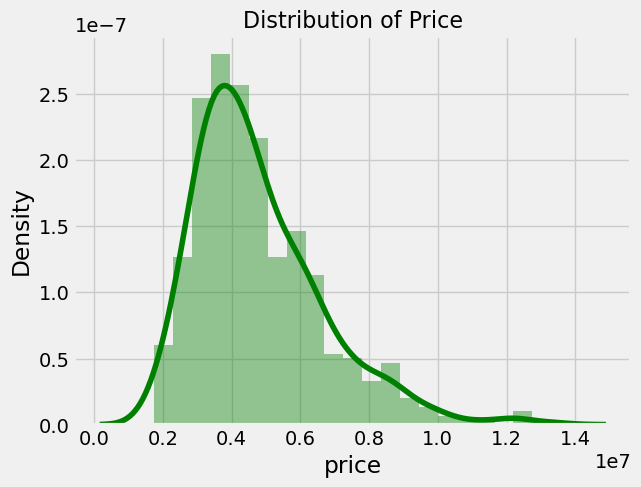

In [209]:
df.isna().sum()
sns.distplot(df['price'], color='green')
plt.title('Distribution of Price',fontsize=16)

Text(0.5, 1.0, 'Distribution of Price after log transformation')

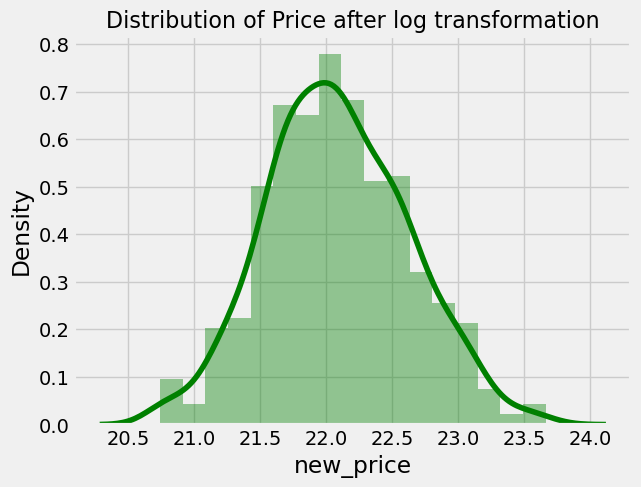

In [210]:
#From the distribution plot there are noticeable biases because the target column is right skewed and can be corrected with the log transformation.
df['new_price'] = np.log2(df["price"])

sns.distplot(df['new_price'], color='green')
plt.title('Distribution of Price after log transformation',fontsize=16)

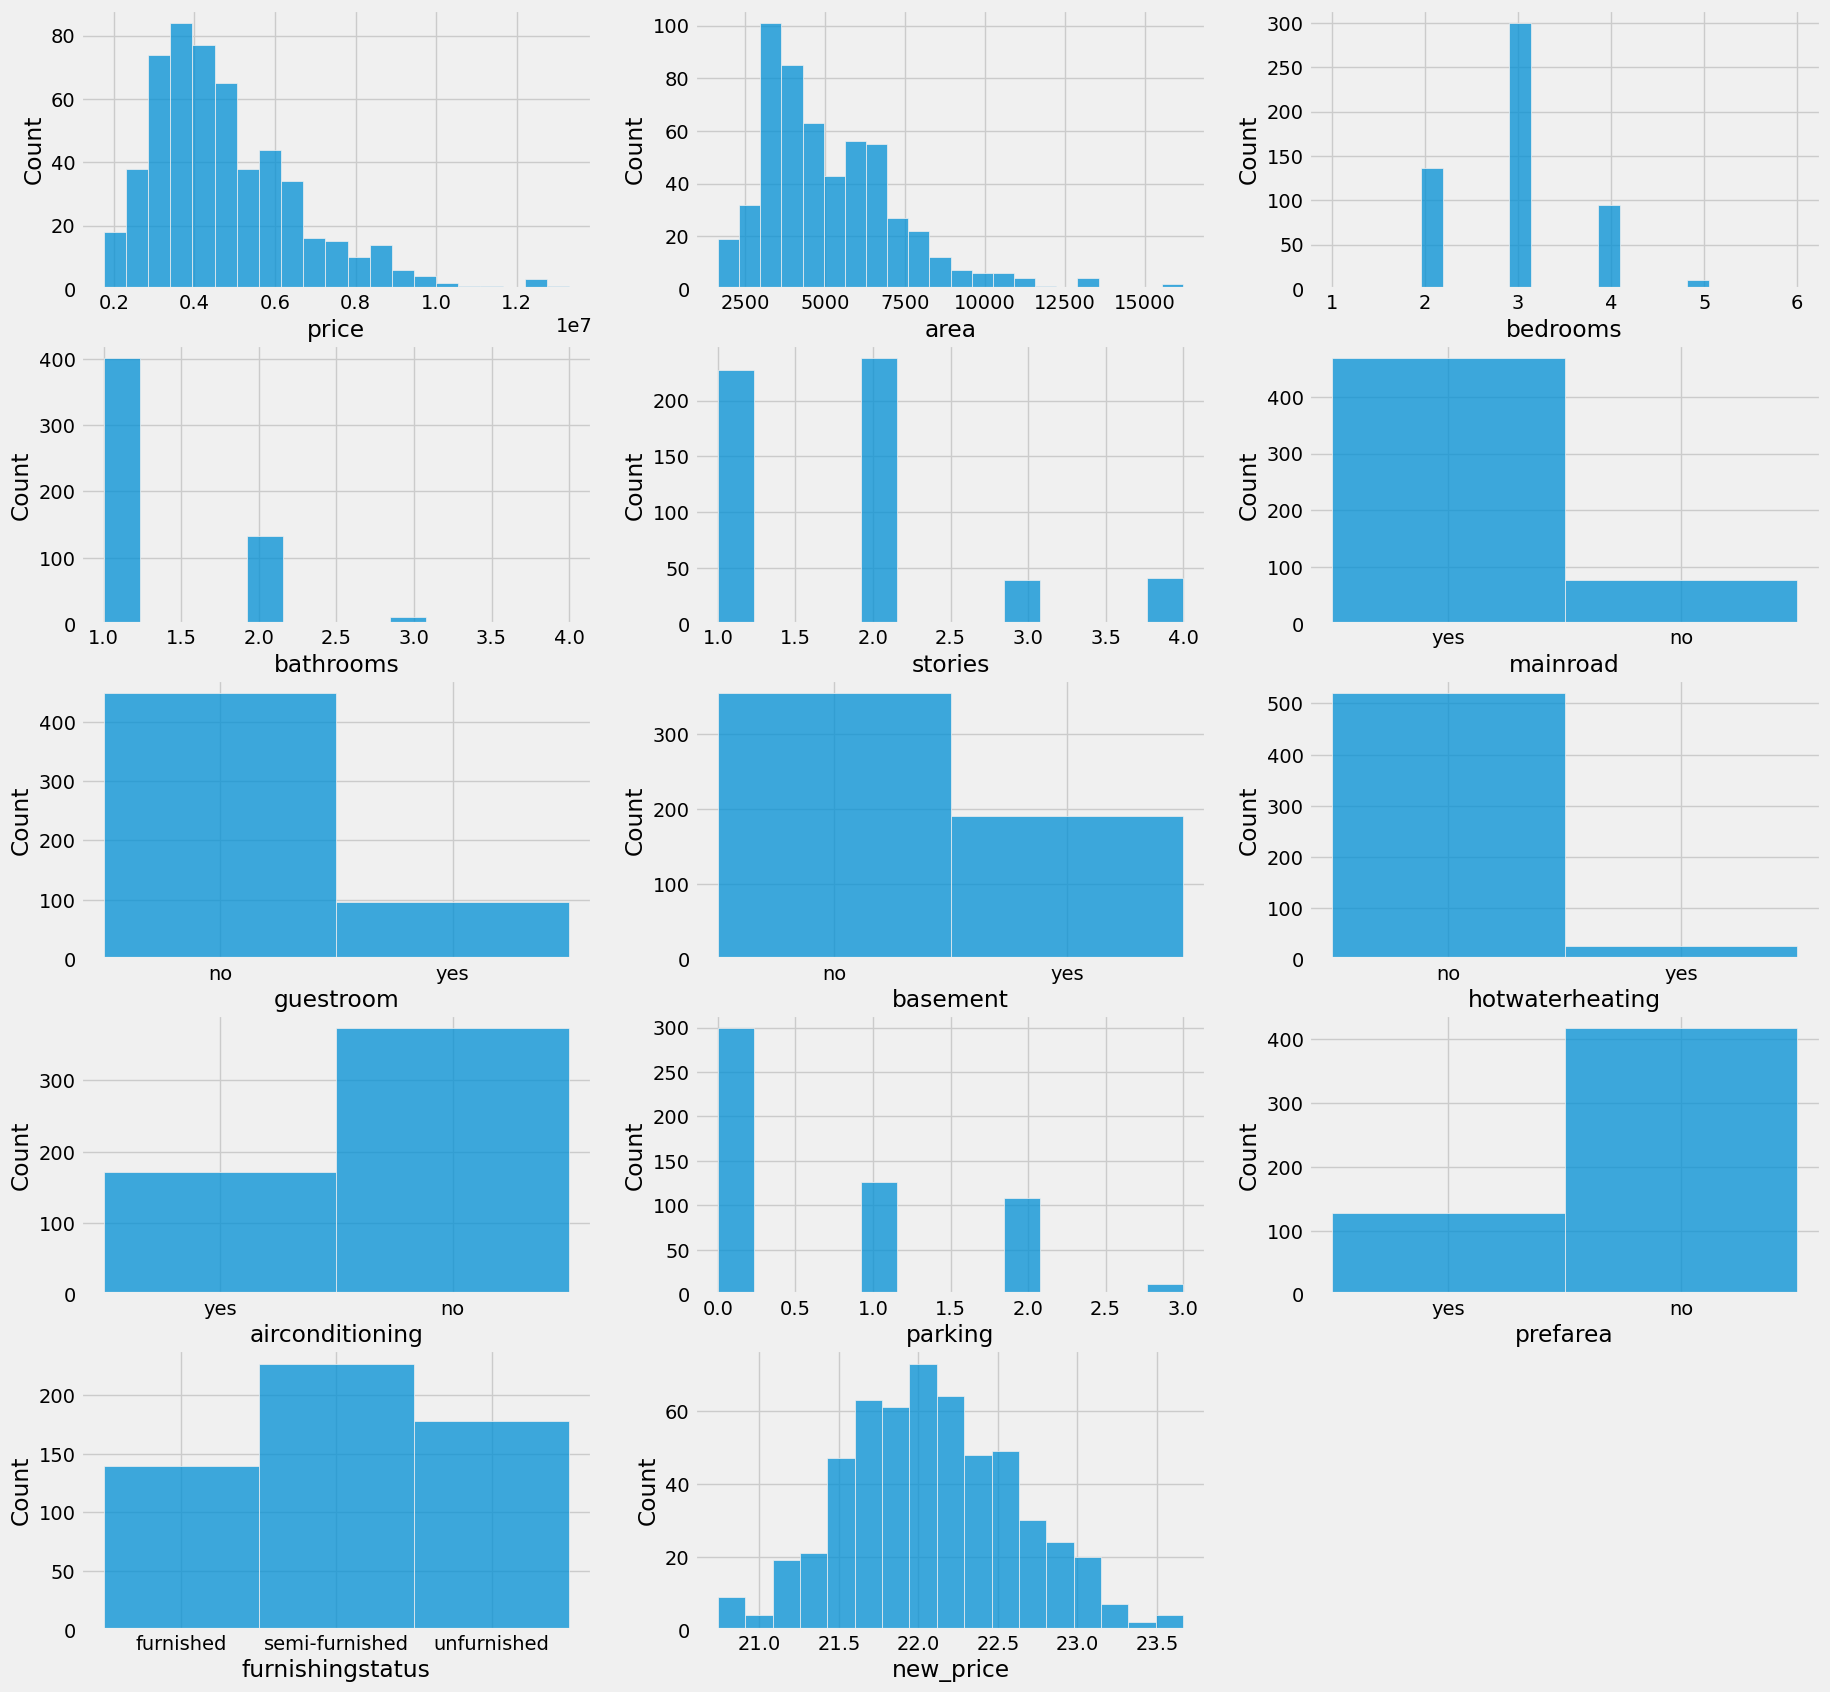

In [211]:
fig, axes = plt.subplots(5, 3, figsize=(20, 20))

for ax in axes.flatten():
    ax.set_axis_off()

for col, ax in zip(df.columns, axes.flatten()):
    ax.set_axis_on()
    sns.histplot(data=df, x=col, ax=ax)

### 2. data processing and correlation analysis

In [212]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
# turn 'yes' and 'no' to 1 and 0
cat_data = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for i in cat_data:
    df[i] = lb.fit_transform(df[i])

In [213]:
# Creating dummy variables for the feature 'furnishingstatus'
status = pd.get_dummies(df['furnishingstatus'])

# Adding the results to the original housing dataframe
df = pd.concat([df, status], axis=1)

df.drop(['furnishingstatus'], axis=1, inplace=True)

df['furnished'] = df['furnished'].astype(int)
df['semi-furnished'] = df['semi-furnished'].astype(int)
df['unfurnished'] = df['unfurnished'].astype(int)

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,new_price,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,24,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,24,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,24,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,24,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,23,1,0,0


In [214]:
correlation_matrix = df.corr()
predictor = correlation_matrix['new_price'].sort_values(ascending=False)

predictor

new_price          1
price              1
area               1
bathrooms          0
airconditioning    0
stories            0
parking            0
bedrooms           0
prefarea           0
mainroad           0
guestroom          0
furnished          0
basement           0
semi-furnished     0
hotwaterheating    0
unfurnished       -0
Name: new_price, dtype: float64

In [215]:
df.corr()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,new_price,furnished,semi-furnished,unfurnished
price,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,-0
area,1,1,0,0,0,0,0,0,-0,0,0,0,1,0,0,-0
bedrooms,0,0,1,0,0,-0,0,0,0,0,0,0,0,0,0,-0
bathrooms,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0
stories,0,0,0,0,1,0,0,-0,0,0,0,0,0,0,-0,-0
mainroad,0,0,-0,0,0,1,0,0,-0,0,0,0,0,0,0,-0
guestroom,0,0,0,0,0,0,1,0,-0,0,0,0,0,0,0,-0
basement,0,0,0,0,-0,0,0,1,0,0,0,0,0,0,0,-0
hotwaterheating,0,-0,0,0,0,-0,-0,0,1,-0,0,-0,0,-0,0,-0
airconditioning,0,0,0,0,0,0,0,0,-0,1,0,0,0,0,-0,-0


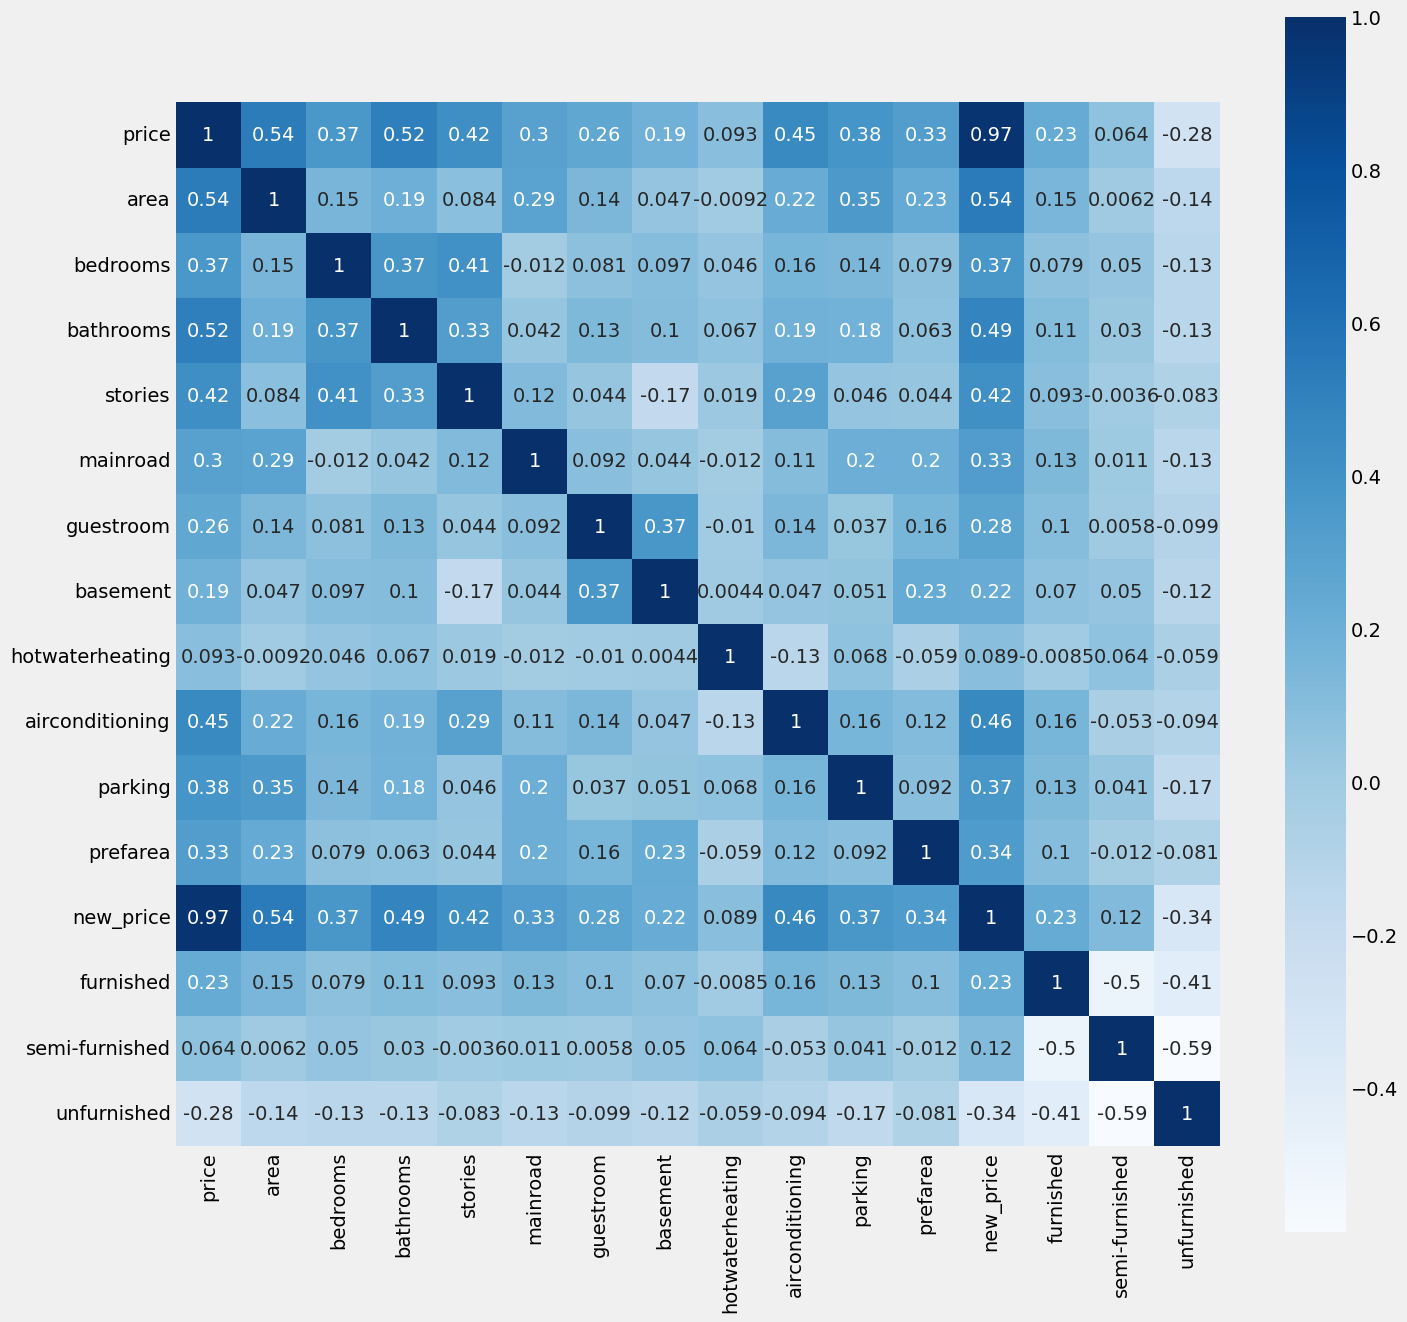

In [216]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, cmap='Blues', annot=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

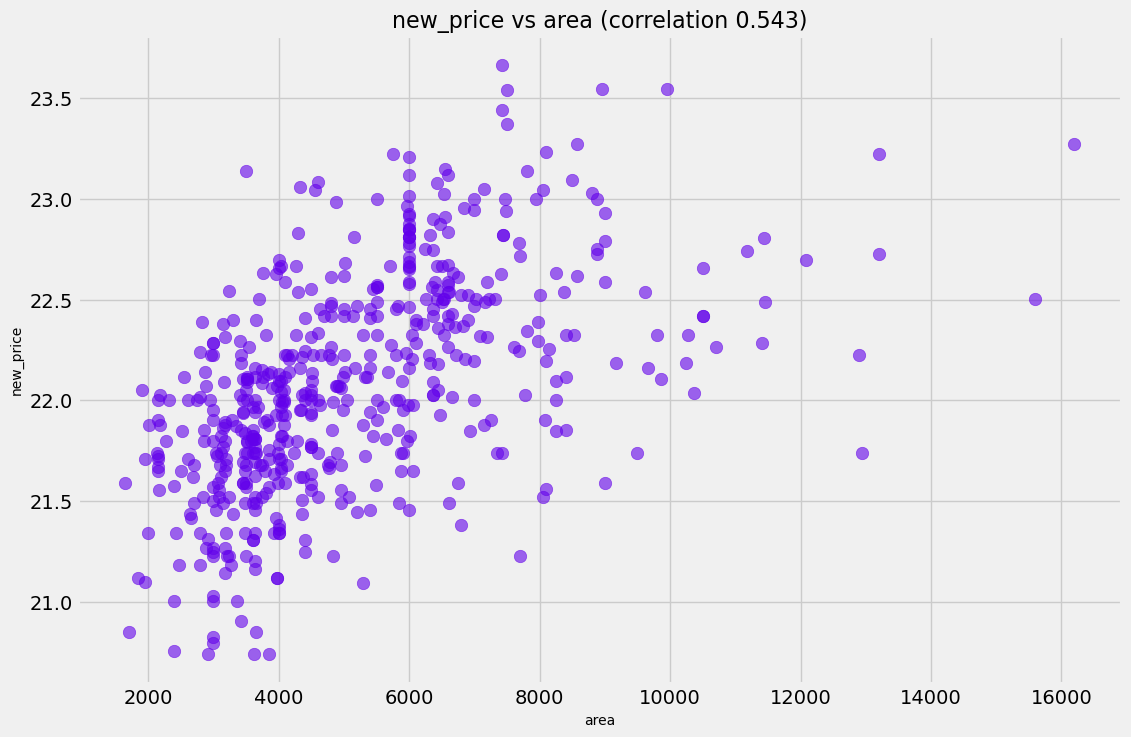

In [272]:
#scatter plot of price vs area
nox_dis_corr = round(df['new_price'].corr(df['area']), 3)
plt.figure(figsize=(12, 8))
plt.scatter(x=df['area'], y=df['new_price'], alpha=0.6, s=80, color='#6200ea')
plt.title(f'new_price vs area (correlation {nox_dis_corr})', fontsize=16)
plt.xlabel('area', fontsize=10)
plt.ylabel('new_price', fontsize=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

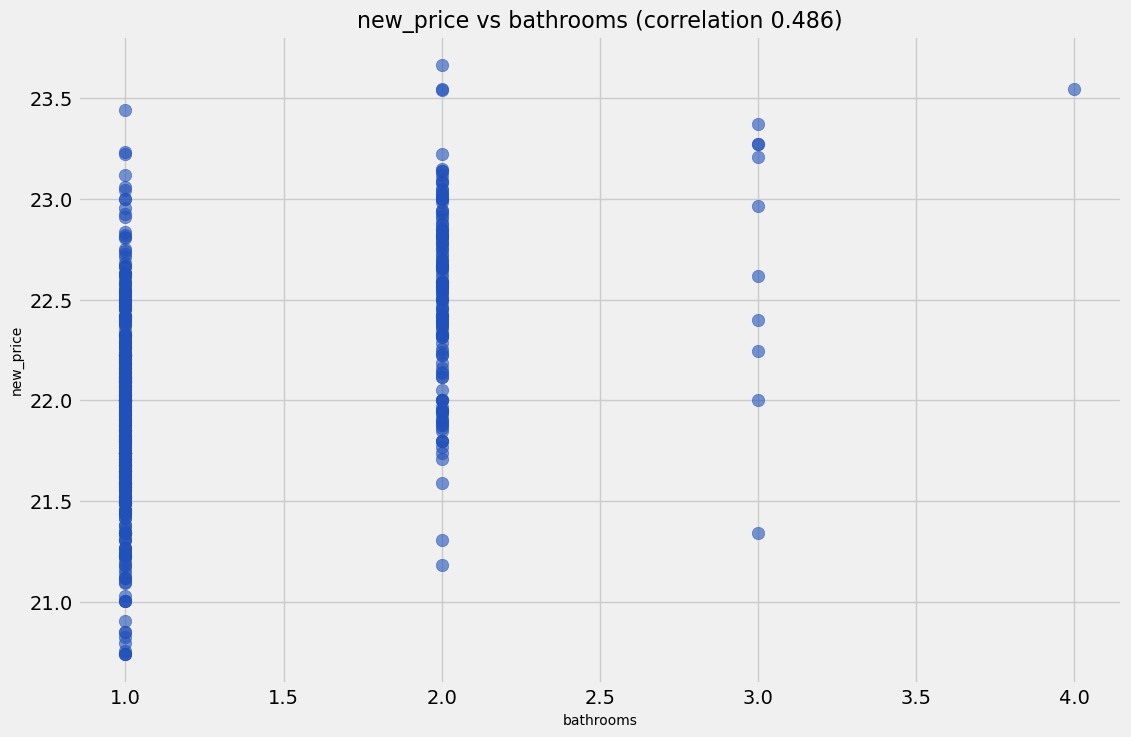

In [273]:
#scatter plot of price vs area
nox_dis_corr = round(df['new_price'].corr(df['bathrooms']), 3)
plt.figure(figsize=(12, 8))
plt.scatter(x=df['bathrooms'], y=df['new_price'], alpha=0.6, s=80, color='#2050ba')
plt.title(f'new_price vs bathrooms (correlation {nox_dis_corr})', fontsize=16)
plt.xlabel('bathrooms', fontsize=10)
plt.ylabel('new_price', fontsize=10)
plt.show

### Splitting the data

In [219]:
x = df.drop('new_price', axis=1)
y = df.new_price

In [220]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=666)

In [221]:
y_train.head()

143   22
240   22
104   23
307   22
290   22
Name: new_price, dtype: float64

In [222]:
# Spliting the dataset into input and ouput or features and target
X = df[['area', 'bathrooms', 'bedrooms', 'parking', 'stories', 'airconditioning', 'furnished', 'semi-furnished',
        'unfurnished', 'prefarea', 'mainroad']]  # features
Y = df['new_price']  # Target

### Scaling the data

In [227]:
# Spliting the dataset into input and ouput or features and target
X = np.asarray(df.drop(['price', 'new_price'], axis=1))  # features
Y = np.asarray(df['new_price'])  # Target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=12)
# Standardizing the datasets to rescale the features to have a mean and varience of 0 and 1 respectively
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train)
scaled_XX = scaler.transform(X_test)

In [228]:
print(X)
print(Y)

[[7420    4    2 ...    1    0    0]
 [8960    4    4 ...    1    0    0]
 [9960    3    2 ...    0    1    0]
 ...
 [3620    2    1 ...    0    0    1]
 [2910    3    1 ...    1    0    0]
 [3850    3    1 ...    0    0    1]]
[23.66492291 23.54627841 23.54627841 23.54215053 23.44379546 23.37119171
 23.27497639 23.27497639 23.23461865 23.22435032 23.22435032 23.20672465
 23.15034974 23.13946142 23.13946142 23.11743511 23.11743511 23.0950673
 23.08375199 23.07806088 23.06085159 23.04926361 23.04343453 23.04343453
 23.03170524 23.02580464 23.01273774 23.0019579  23.0019579  23.0019579
 23.0019579  23.0019579  22.98381055 22.96543202 22.9530483  22.94609169
 22.93930229 22.92795732 22.92479004 22.91524626 22.90884849 22.90242222
 22.87642702 22.87642702 22.8499548  22.8499548  22.84326015 22.83653429
 22.82977692 22.82298776 22.82298776 22.82298776 22.80931282 22.80931282
 22.80931282 22.80931282 22.80793817 22.78855426 22.78156783 22.78156783
 22.76749264 22.75327878 22.75327878 22.7461

### LinearRegression

In [229]:
model = LinearRegression()  # Instanstiating the linear regression model for use
model.fit(scaled_X, Y_train)

LinearRegression()

In [238]:
X_train_prediction = model.predict(scaled_X)
error_score = metrics.r2_score(Y_train, X_train_prediction)
print('R square error : ', error_score)

R square error :  0.6783871252832968


In [239]:
pred = model.predict(scaled_X)
mean_absolute_error(Y_train, pred)

0.22989419390557586

In [240]:
pred = model.predict(scaled_X)
mean_squared_error(Y_train, pred)

0.0851137211710764

In [263]:
print("training accuracy with liner regression ", model.score(scaled_X, Y_train))

training accuracy with liner regression  0.6783871252832968


In [264]:
print("testing accuracy with liner regression ", model.score(scaled_XX, Y_test))

testing accuracy with liner regression  0.7164666058372056


### Decision Tree

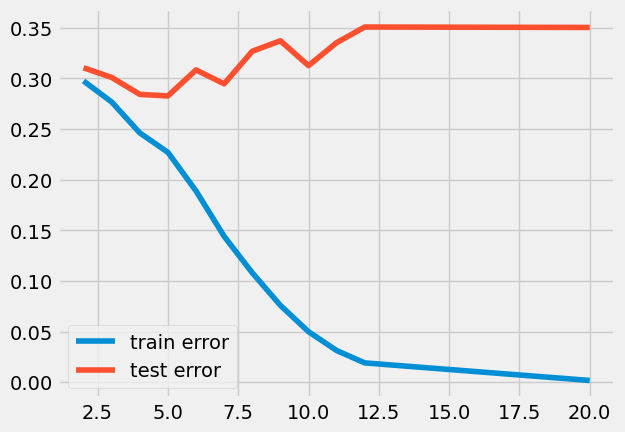

In [127]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20]
train_error = []
test_error = []

for md in max_depth_list:
    decisiontree = DecisionTreeRegressor(max_depth=md, min_samples_split=2)
    decisiontree.fit(scaled_X, Y_train)
    train_error.append(mean_absolute_error(Y_train, decisiontree.predict(scaled_X)))
    test_error.append(mean_absolute_error(Y_test, decisiontree.predict(scaled_XX)))

plt.plot(max_depth_list, train_error, label='train error')
plt.plot(max_depth_list, test_error, label='test error')
plt.legend()

In [128]:
tree_model = DecisionTreeRegressor(max_depth=4)
tree_model.fit(scaled_X, Y_train)

DecisionTreeRegressor(max_depth=4)

In [243]:
pred = tree_model.predict(scaled_X)
mean_absolute_error(Y_train, pred)

0.24622992595825102

In [244]:
pred = model.predict(scaled_X)
mean_squared_error(Y_train, pred)

0.0851137211710764

In [259]:
print("training accuracy with decision tree ", tree_model.score(scaled_X, Y_train))

training accuracy with random forest  0.619304583321586


In [260]:
print("testing accuracy with decision tree ", tree_model.score(scaled_XX, Y_test))

testing accuracy with random forest  0.586556450884991


### RandomForestRegressor

In [133]:
from sklearn.ensemble import RandomForestRegressor

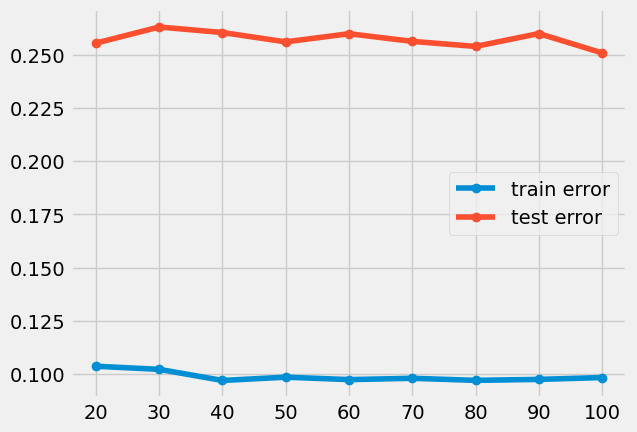

In [134]:
max_depth_list = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
train_error = []
test_error = []
N_estimator = [20, 30, 40, 50, 60, 70, 80, 90, 100]
for n in N_estimator:
    decisiontree = RandomForestRegressor(n_estimators=n, max_depth=12, min_samples_split=2)
    decisiontree.fit(scaled_X, Y_train)
    train_error.append(mean_absolute_error(Y_train, decisiontree.predict(scaled_X)))
    test_error.append(mean_absolute_error(Y_test, decisiontree.predict(scaled_XX)))

plt.plot(N_estimator, train_error, marker='o', label='train error')
plt.plot(N_estimator, test_error, marker='o', label='test error')
plt.legend()

In [135]:
forest_model = RandomForestRegressor()
forest_model.fit(scaled_X, Y_train)

RandomForestRegressor()

In [247]:
pred = forest_model.predict(scaled_X)
mean_absolute_error(Y_train, pred)

0.09618133567064992

In [254]:
pred = forest_model.predict(scaled_X)
mean_squared_error(Y_train, pred)

0.015673950967141134

In [256]:
print("training accuracy with random forest ", forest_model.score(scaled_X, Y_train))

training accuracy with random forest  0.9407740096502333


In [258]:
print("testing accuracy with random forest ", forest_model.score(scaled_XX, Y_test))

testing accuracy with random forest  0.6491912605335076


### Ridge

0.23179238804545924 0.31124524156468897


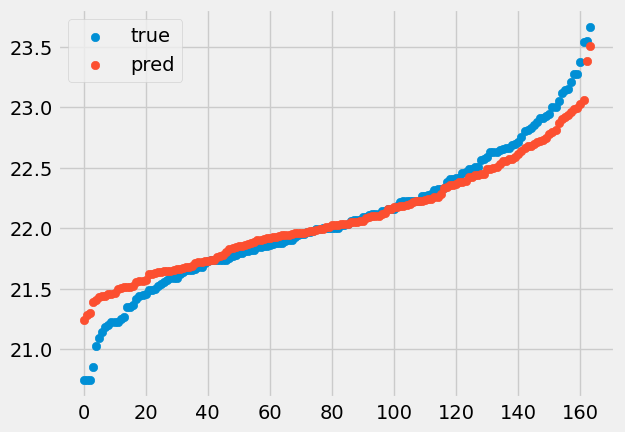

In [280]:
ridge = Ridge(alpha=1)
ridge.fit(scaled_X,Y_train)
y_pred = ridge.predict(scaled_XX)
print(mean_absolute_error(Y_test,y_pred), mean_squared_error(Y_test,y_pred)**0.5)

plt.scatter(np.arange(len(np.sort(Y_test))),np.sort(Y_test), label='true')
plt.scatter(np.arange(len(np.sort(y_pred))),np.sort(y_pred), label = 'pred')
plt.legend()

In [281]:
pred = ridge.predict(scaled_X)
mean_absolute_error(Y_train, pred)

0.2298787639265198

In [282]:
pred = ridge.predict(scaled_X)
mean_squared_error(Y_train, pred)

0.08511402327875969

In [283]:
print("training accuracy with ridge ", ridge.score(scaled_X, Y_train))

training accuracy with ridge  0.6783859837315098


In [284]:
print("testing accuracy with ridge ", ridge.score(scaled_XX, Y_test))

testing accuracy with ridge  0.7162792659532032
